<img src=https://a-static.projektn.sk/2020/11/Startup.jpg>

# Startup Profit Prediction

# 1. Reading and Understanding the Data

In [1]:
#basic libraries and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#statmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
#sklearn-dataprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import f_regression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error
#sklearn-models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_theme(style='darkgrid', palette='Accent')
pd.options.display.float_format = '{:,.2f}'.format

**About the dataset:**

This dataset has data collected from New York, California and Florida about 50 business Startups. 
The variables used in the dataset are Profit, R&D spending(research and development), Administration Spending, and Marketing Spending.


In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/d/farhanmd29/50-startups/50_Startups.csv


In [5]:
startups = pd.read_csv("/kaggle/input/d/farhanmd29/50-startups/50_Startups.csv")
startups.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,"165,349.20","136,897.80","471,784.10",New York,"192,261.83"
1,"162,597.70","151,377.59","443,898.53",California,"191,792.06"
2,"153,441.51","101,145.55","407,934.54",Florida,"191,050.39"
3,"144,372.41","118,671.85","383,199.62",New York,"182,901.99"
4,"142,107.34","91,391.77","366,168.42",Florida,"166,187.94"


In [6]:
startups.shape

(50, 5)

In [7]:
startups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [8]:
startups.isnull().sum()

R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

In [9]:
startups.duplicated().any()

False

In [10]:
startups.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.00,50.00,50.00,50.00
mean,"73,721.62","121,344.64","211,025.10","112,012.64"
std,"45,902.26","28,017.80","122,290.31","40,306.18"
min,0.00,"51,283.14",0.00,"14,681.40"
25%,"39,936.37","103,730.88","129,300.13","90,138.90"
50%,"73,051.08","122,699.79","212,716.24","107,978.19"
75%,"101,602.80","144,842.18","299,469.08","139,765.98"
max,"165,349.20","182,645.56","471,784.10","192,261.83"


# 2. EDA

## Checking for outliers

In [11]:
startups.columns.values

array(['R&D Spend', 'Administration', 'Marketing Spend', 'State',
       'Profit'], dtype=object)

<AxesSubplot:>

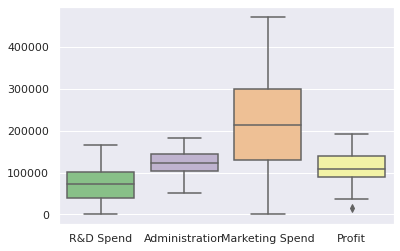

In [12]:
sns.boxplot(data=startups)

In [13]:
# We can see that in the Profit column we have an outlier. Since we have a small dataset, this could be a problem
# in predicting the profit, hence, we are going to remove this outlier.
Q3, Q1 = np.percentile(startups["Profit"], [75 ,25])
IQR = Q3 - Q1
startups = startups[~(startups.Profit< (Q1 - 1.5*IQR))]

## Visualising Numerical Variables

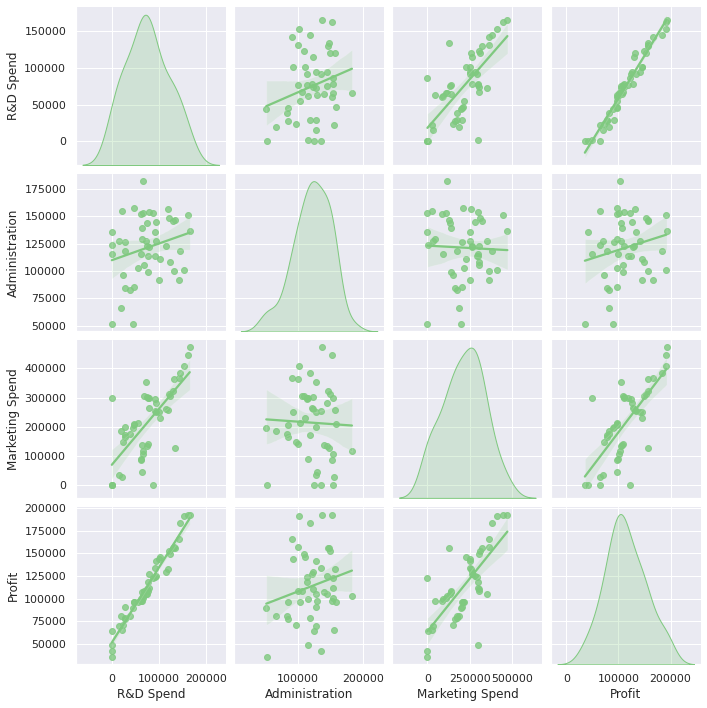

In [14]:
sns.pairplot(startups[['R&D Spend', 'Administration', 'Marketing Spend', 'Profit']], kind="reg", diag_kind="kde")
plt.show()

**Insights:**

1. We can see normal distributions of numerical variables. 

2. R&D Spend and Marketing Spend are in linear relation with target variable.

### Profit Distribution

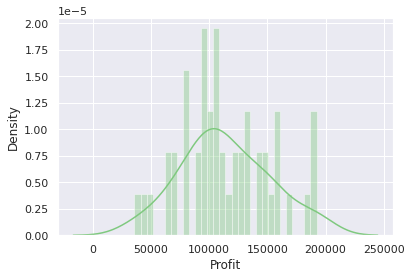

In [15]:
sns.distplot(startups["Profit"], bins=30)
plt.show()

### R&D Spend vs. Profit Correlation

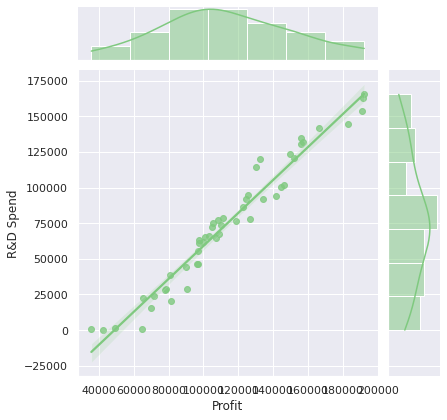

In [16]:
sns.jointplot(x=startups["Profit"], y=startups["R&D Spend"], kind="reg")
plt.show()

## Visualising Categorical Variables

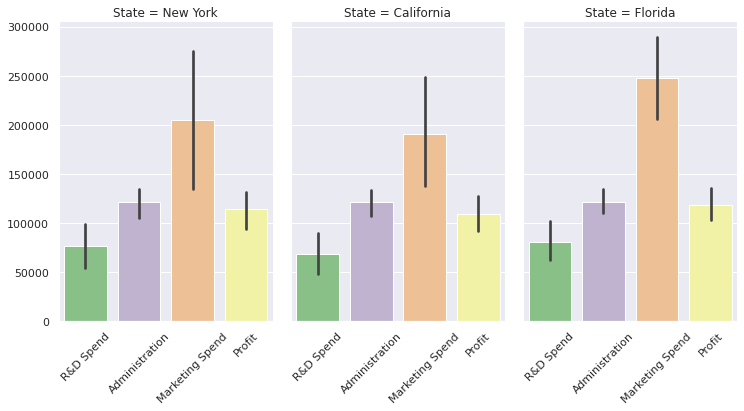

In [17]:
g=sns.FacetGrid(data=startups, col="State", height=5, aspect=0.7)
g.map_dataframe(sns.barplot, palette="Accent")
g.set_xticklabels(rotation=45)
plt.show()


**Insights:**
1. Profits and Marketing Spend are higher at Florida than other states.
2. R&D Spend and Administration are same for all of the states.

#  3. Data Preparation

In [18]:
startups_prepared = startups.copy()

## Checking for multicollinearity

In [19]:
numerical = startups_prepared.drop(columns=["State", "Profit"])
vif = pd.DataFrame()
vif["Features"] = numerical.columns
vif["VIF"] = [variance_inflation_factor(numerical.values, i) for i in range(numerical.shape[1])]
vif["VIF"] = round(vif["VIF"], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,R&D Spend,8.60
2,Marketing Spend,7.59
1,Administration,4.22


**Insights:**
1. VIF scores are higher for R&D and Marketing Spend.
2. Since Administration is not so correlated with Profit as other variables, we will consider dropping this variable, which will drive VIF factor down.


## Creating dummy variables

In [20]:
startups_prepared = pd.get_dummies(startups_prepared, drop_first=True)
startups_prepared.rename(columns={"R&D Spend":"R&D", "Marketing Spend":"Marketing", 
                         "State_Florida":"Florida", "State_New York":"New York"}, inplace=True)

In [21]:
startups_prepared.head()

,R&D,Administration,Marketing,Profit,Florida,New York
0,"165,349.20","136,897.80","471,784.10","192,261.83",0,1
1,"162,597.70","151,377.59","443,898.53","191,792.06",0,0
2,"153,441.51","101,145.55","407,934.54","191,050.39",1,0
3,"144,372.41","118,671.85","383,199.62","182,901.99",0,1
4,"142,107.34","91,391.77","366,168.42","166,187.94",1,0


## Defining input and target variables

In [22]:
X = startups_prepared.drop(columns="Profit")
y = startups_prepared.Profit

## Feature selection

In [23]:
data = f_regression(X[["R&D", "Administration", "Marketing"]], y)
f_df = pd.DataFrame(data, index=[["F_statistic", "p_value"]], columns=X[["R&D", "Administration", "Marketing"]].columns).T
f_df

,F_statistic,p_value
R&D,"1,054.72",0.00
Administration,2.08,0.16
Marketing,56.66,0.00


**Insights:**
1. R&D and Marketing has nearly 0 p-value what implies statistical significance.
2. On the other hand Administration seems to have no effect in predicting the Profit, as we previously seen from correlation as well.
3. We are going to drop Administration column as it has no statistical significance in our model.

In [24]:
X = X.drop(columns="Administration")

## Splitting the Data into Training and Testing Sets

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=6)

In [26]:
#Checking if the split has approximately equal distributions of values
print(f"Train Florida: {X_train['Florida'].mean()}")
print(f"Test Florida: {X_test['Florida'].mean()}")
print(f"Train Marketing: {X_train['Marketing'].mean()}")
print(f"Test Marketing: {X_test['Marketing'].mean()}")

Train Florida: 0.3125
Test Florida: 0.35294117647058826
Train Marketing: 235405.88625
Test Marketing: 174887.8511764706


## Scaling the Features

In [27]:
#scaling inputs
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)
#scaling target variable
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train.values.reshape(-1, 1))
y_test = sc_y.transform(y_test.values.reshape(-1, 1))

In [28]:
y_train = y_train.reshape(32)
y_test = y_test.reshape(17)

# 4. Model Selection and Evaluation

## Multiple Linear regression

In [29]:
Rsqr_test = []
order = range(1,4)
for n in order:
    pr = PolynomialFeatures(degree=n)
    X_train_poly = pr.fit_transform(X_train)
    X_test_poly = pr.fit_transform(X_test)
    lr = LinearRegression()
    lr.fit(X_train_poly, y_train)
    Rsqr_test.append(lr.score(X_test_poly, y_test))
Rsqr_test

[0.9484473292910411, 0.8740499826901039, 0.6029774988290402]

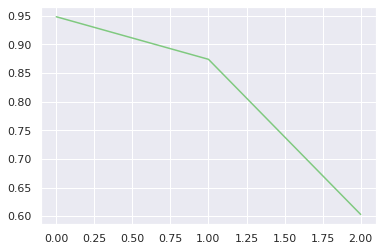

In [30]:
plt.plot(Rsqr_test)
plt.show()

## Support Vector regression

In [31]:
svr = SVR()
svr.fit(X_train, y_train)
svr.score(X_test, y_test)

0.8110028798022219

## Decision Tree regression

In [32]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.8900387438500195

## Random Forest regression

In [33]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.917982416292364

#### The best performing model is Multiple Linear Regression.

In [34]:
lr = LinearRegression()
lr.fit(X_train, y_train)
r2_score = lr.score(X_test, y_test)

In [35]:
# Adjusted R-square of the model
n = X_test.shape[0]
p = X_test.shape[1]

adjusted_r2 = 1-(1-r2_score)*(n-1)/(n-p-1)
adjusted_r2

0.9312631057213885

# 5. Residuals analysis

In [36]:
y_test_hat = lr.predict(X_test)

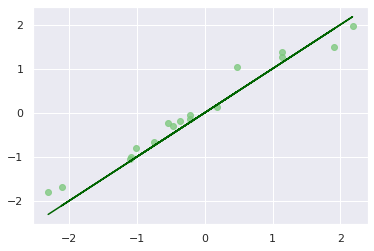

In [37]:
plt.scatter(x=y_test, y=y_test_hat, alpha=0.8)
plt.plot(y_test, y_test, color='darkgreen')
plt.show()

In [38]:
residuals = y_test - y_test_hat

The errors should not follow any pattern and equally distributed.

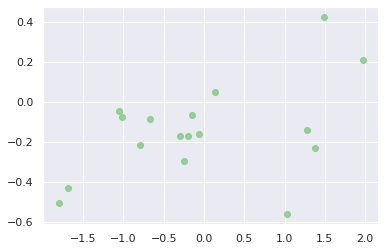

In [39]:
plt.scatter(y=residuals, x=y_test_hat, alpha=0.8)
plt.show()

In [40]:
lr.coef_

array([ 0.96049786,  0.0109726 , -0.01004952, -0.06425628])

In [41]:
lr.intercept_

-3.7723824852866906e-16

## Our preferred model now has an equation that looks like this:

## $$ PROFIT = -3.77 + 0.96 * R&D Spend + 0.01 * Marketing Spend + (-0.01) * Florida + (-0.06) * NewYork $$

Note: Since we scaled the data for modeling, if we want to predict profits, we have to perform inverse_transform() on the predicted values.